# CNN_3channel_InceptionV3_FineTune

Abstract:
- single channel: band_avg
- CNN, small net

Result:
- 增大网络的各个参数，只是把train数据的拟合程度增加了（到了99%），而cv数据的泛化能力仍然只有87%，说明，特征还需要进一步的提取来增加系统的泛化能力。

References:
- https://www.kaggle.com/ivalmian/simple-svd-xgboost-baseline-lb-35
- https://www.kaggle.com/arieltci/a-keras-prototype-0-21174-on-pl

## 1. Preprocess

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display

%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2

import gc

### Run name

In [3]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'CNN_3channel_InceptionV3_FineTune'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: SC_Iceberg_Classifier_CNN_3channel_InceptionV3_FineTune_20180111_141811


### Folder Pathes

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/input
log_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/log
model_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/model
output_path: /data1/Kaggle/statoil-iceberg-classifier-challenge/output


### Unzip files

In [5]:
# with lzma.open("train.json.7z") as f:
#     file_content = f.read()

In [6]:
# Unzip(input_path, os.path.join(input_path, 'sample_submission.csv.7z'))
# Unzip(input_path, os.path.join(input_path, 'test.json.7z'))
# Unzip(input_path, os.path.join(input_path, 'train.json.7z'))

### Basic functions

In [7]:
import sys
def describe(arr):
    print(arr.shape, arr.min(), arr.max(), sys.getsizeof(arr))

### Load data

In [8]:
sample_submission_path = os.path.join(input_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.shape)
sample_submission.head(2)

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5


In [9]:
is_iceberg_path = os.path.join(input_path, 'is_iceberg.p')
y_data = pickle.load(open(is_iceberg_path, mode='rb'))
describe(y_data)

(1604,) 0 1 25688


In [10]:
%%time
#Load orignal data
inc_angle_data_path = os.path.join(input_path, 'inc_angle_data.p')
inc_angle_test_path = os.path.join(input_path, 'inc_angle_test.p')

inc_angle_data = pickle.load(open(inc_angle_data_path, mode='rb'))
inc_angle_test = pickle.load(open(inc_angle_test_path, mode='rb'))

describe(inc_angle_data)
describe(inc_angle_test)

(1604,) 0.0 45.9375 25688
(8424,) 23.0805 50.66178518000562 134808
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.9 ms


In [11]:
%%time
#Load orignal data
target_size = 150
band1_data_path = os.path.join(input_path, 'band1_data_gray%s.p' % target_size)
band2_data_path = os.path.join(input_path, 'band2_data_gray%s.p' % target_size)
band1_test_path = os.path.join(input_path, 'band1_test_gray%s.p' % target_size)
band2_test_path = os.path.join(input_path, 'band2_test_gray%s.p' % target_size)
print(band1_data_path)
band1_data = pickle.load(open(band1_data_path, mode='rb'))
band2_data = pickle.load(open(band2_data_path, mode='rb'))
band1_test = pickle.load(open(band1_test_path, mode='rb'))
band2_test = pickle.load(open(band2_test_path, mode='rb'))

describe(band1_data)
describe(band2_data)
describe(band1_test)
describe(band2_test)

/data1/Kaggle/statoil-iceberg-classifier-challenge/input/band1_data_gray150.p
(1604, 150, 150) 0.0045049769842293854 0.9985847482054284 128
(1604, 150, 150) 0.00917876748469312 0.9994694902705856 128
(8424, 150, 150) 0.0 1.0 128
(8424, 150, 150) 0.0 1.0 128
CPU times: user 1.61 s, sys: 3.74 s, total: 5.35 s
Wall time: 5.34 s


In [12]:
%%time
#Load orignal data
band_sub_data = np.fabs(np.subtract(band1_data, band2_data))
band_sub_test = np.fabs(np.subtract(band1_test, band2_test))
band_min_data = np.minimum(band1_data, band2_data)
band_min_test = np.minimum(band1_test, band2_test)
band_max_data = np.maximum(band1_data, band2_data)
band_max_test = np.maximum(band1_test, band2_test)

describe(band_sub_data)
describe(band_sub_test)
describe(band_min_data)
describe(band_min_test)
describe(band_max_data)
describe(band_max_test)

(1604, 150, 150) 6.708432698232514e-10 0.8410463008526331 288720128
(8424, 150, 150) 0.0 0.8432859534298787 1516320128
(1604, 150, 150) 0.0045049769842293854 0.9964643293502019 288720128
(8424, 150, 150) 0.0 1.0 1516320128
(1604, 150, 150) 0.06541670375958838 0.9994694902705856 288720128
(8424, 150, 150) 0.012590287516197897 1.0 1516320128
CPU times: user 3.43 s, sys: 2.8 s, total: 6.23 s
Wall time: 6.22 s


In [13]:
%%time
#Load orignal data
band_sub_data = np.fabs(np.subtract(band1_data, band2_data))
band_sub_test = np.fabs(np.subtract(band1_test, band2_test))
band_min_data = np.minimum(band1_data, band2_data)
band_min_test = np.minimum(band1_test, band2_test)
band_max_data = np.maximum(band1_data, band2_data)
band_max_test = np.maximum(band1_test, band2_test)

describe(band_sub_data)
describe(band_sub_test)
describe(band_min_data)
describe(band_min_test)
describe(band_max_data)
describe(band_max_test)

(1604, 150, 150) 6.708432698232514e-10 0.8410463008526331 288720128
(8424, 150, 150) 0.0 0.8432859534298787 1516320128
(1604, 150, 150) 0.0045049769842293854 0.9964643293502019 288720128
(8424, 150, 150) 0.0 1.0 1516320128
(1604, 150, 150) 0.06541670375958838 0.9994694902705856 288720128
(8424, 150, 150) 0.012590287516197897 1.0 1516320128
CPU times: user 3.39 s, sys: 2.94 s, total: 6.34 s
Wall time: 6.33 s


In [14]:
%%time
x_data = np.concatenate([band1_data[:, :, :, np.newaxis],
                         band2_data[:, :, :, np.newaxis],
                         band_max_data[:, :, :, np.newaxis]], axis=-1)
describe(x_data)
# del band1_data
# del band2_data
# del band_avg_data
gc.collect()

x_test = np.concatenate([band1_test[:, :, :, np.newaxis],
                         band2_test[:, :, :, np.newaxis],
                         band_max_test[:, :, :, np.newaxis]], axis=-1)
describe(x_test)
# del band1_test
# del band2_test
# del band_avg_test
gc.collect()

(1604, 150, 150, 3) 0.0045049769842293854 0.9994694902705856 866160144
(8424, 150, 150, 3) 0.0 1.0 4548960144
CPU times: user 3.28 s, sys: 2.02 s, total: 5.3 s
Wall time: 5.3 s


In [15]:
%%time
x_train, x_val, inc_angle_train, inc_angle_val, y_train, y_val = train_test_split(x_data, inc_angle_data, y_data, test_size=0.1, random_state=31)
describe(x_train)
describe(x_val)
describe(inc_angle_train)
describe(inc_angle_val)
describe(y_train)
describe(y_val)

(1443, 150, 150, 3) 0.0045049769842293854 0.9994694902705856 779220144
(161, 150, 150, 3) 0.009640460801675846 0.997560227352376 86940144
(1443,) 0.0 45.9375 23112
(161,) 0.0 45.2814 2600
(1443,) 0 1 23112
(161,) 0 1 2600
CPU times: user 308 ms, sys: 324 ms, total: 632 ms
Wall time: 624 ms


## 2. Build model

In [16]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19, preprocess_input

/root/anaconda3/envs/python35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
def build_model():
    base_model = InceptionV3(weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in model.layers[:]:
       layer.trainable = True

#     for layer in model.layers[:249]:
#        layer.trainable = False
#     for layer in model.layers[249:]:
#        layer.trainable = True

    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [18]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [19]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
# saveModel(model, 'saveModel_test')

In [20]:
def get_lr(x):
    lr = round(1e-4 * 0.995 ** x, 6)
    if lr < 1e-5:
        lr = 1e-5
    print(lr, end='  ')
    return lr

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

callbacks = []

log_dir:/data1/Kaggle/statoil-iceberg-classifier-challenge/log/SC_Iceberg_Classifier_CNN_3channel_InceptionV3_FineTune_20180111_141811


In [21]:
datagen = ImageDataGenerator(
    zoom_range = 0.2,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.3
)

In [22]:
%%time
batch_size = 64
steps_per_epoch = x_train.shape[0] / batch_size
hist = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True, seed=2019),
    steps_per_epoch=steps_per_epoch,
    epochs=100, #1 for ETA, 0 for silent
    verbose=1,
    max_queue_size=128,
    callbacks=callbacks,
    workers=32,
    validation_data=(x_val, y_val)
)

Epoch 1/100
23/22 [==============================] - 29s 1s/step - loss: 0.5723 - acc: 0.6744 - val_loss: 0.7225 - val_acc: 0.5342
Epoch 2/100
23/22 [==============================] - 17s 742ms/step - loss: 0.4221 - acc: 0.7915 - val_loss: 0.6673 - val_acc: 0.5714
Epoch 3/100
23/22 [==============================] - 19s 810ms/step - loss: 0.3598 - acc: 0.8276 - val_loss: 0.7951 - val_acc: 0.5963
Epoch 4/100
23/22 [==============================] - 18s 803ms/step - loss: 0.3222 - acc: 0.8444 - val_loss: 0.8840 - val_acc: 0.6335
Epoch 5/100
23/22 [==============================] - 19s 807ms/step - loss: 0.3058 - acc: 0.8634 - val_loss: 1.4898 - val_acc: 0.6149
Epoch 6/100
23/22 [==============================] - 18s 783ms/step - loss: 0.2738 - acc: 0.8749 - val_loss: 0.4967 - val_acc: 0.8075
Epoch 7/100
23/22 [==============================] - 19s 821ms/step - loss: 0.2566 - acc: 0.8899 - val_loss: 0.4284 - val_acc: 0.8447
Epoch 8/100
23/22 [==============================] - 18s 800ms/st

Epoch 62/100
23/22 [==============================] - 18s 803ms/step - loss: 0.0721 - acc: 0.9716 - val_loss: 0.6008 - val_acc: 0.8758
Epoch 63/100
23/22 [==============================] - 18s 803ms/step - loss: 0.0854 - acc: 0.9743 - val_loss: 0.5241 - val_acc: 0.8820
Epoch 64/100
23/22 [==============================] - 18s 802ms/step - loss: 0.0647 - acc: 0.9750 - val_loss: 0.4582 - val_acc: 0.8820
Epoch 65/100
23/22 [==============================] - 18s 804ms/step - loss: 0.0645 - acc: 0.9738 - val_loss: 0.4436 - val_acc: 0.8882
Epoch 66/100
23/22 [==============================] - 18s 802ms/step - loss: 0.0556 - acc: 0.9797 - val_loss: 0.4691 - val_acc: 0.9130
Epoch 67/100
23/22 [==============================] - 18s 803ms/step - loss: 0.0428 - acc: 0.9811 - val_loss: 0.5007 - val_acc: 0.9006
Epoch 68/100
23/22 [==============================] - 18s 803ms/step - loss: 0.0484 - acc: 0.9830 - val_loss: 0.5231 - val_acc: 0.9130
Epoch 69/100
23/22 [==============================] - 1

In [23]:
# hist = model.fit(x_train, y_train, 
#                  batch_size = 128, 
#                  verbose= 1,
#                  epochs = 100, #1 for ETA, 0 for silent
#                  validation_data=(x_val, y_val),
#                  callbacks=[annealer, tensorBoard])

In [24]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

161/161 [==============================] - 1s 7ms/step
Final loss: 0.8725, final accuracy: 0.8261


In [26]:
val_prob = model.predict(x_val)

# print('Val log_loss: {}'.format(log_loss(y_val, val_prob1)))
val_prob_limit = np.clip(val_prob, 0.00005, 0.99995)
loss = log_loss(y_val, val_prob_limit)
print('Val log_loss: {}'.format(loss))

val_prob_limit = np.clip(val_prob_limit, 0.05, 0.95)
loss = log_loss(y_val, val_prob_limit)
print('Val log_loss: {}'.format(loss))

Val log_loss: 0.8061396885529593
Val log_loss: 0.49121017217265894


In [27]:
final_acc_str = '{0:0>4}'.format(int(loss*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_InceptionV3_FineTune_20180111_141811_4912


In [28]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


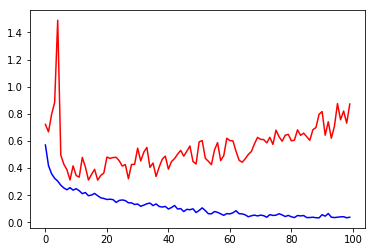

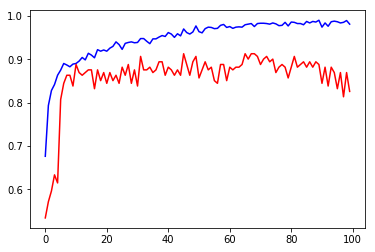

In [29]:
plt.plot(histories['loss'], color='b')
plt.plot(histories['val_loss'], color='r')
plt.show()
plt.plot(histories['acc'], color='b')
plt.plot(histories['val_acc'], color='r')
plt.show()

In [30]:
saveModel(model, run_name_acc)

## 3. Predict

In [31]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

/data1/Kaggle/statoil-iceberg-classifier-challenge/output/SC_Iceberg_Classifier_CNN_3channel_InceptionV3_FineTune_20180111_141811_4912.csv


In [32]:
test_prob = model.predict(x_test)
print(test_prob.shape)
print(test_prob[0:2])
test_prob = np.clip(test_prob, 0.05, 0.95)
print(test_prob.shape)
print(test_prob[0:2])

(8424, 1)
[[0.00207366]
 [0.00532826]]
(8424, 1)
[[0.05]
 [0.05]]


In [33]:
sample_submission['is_iceberg'] = test_prob
print(sample_submission[0:2])
print(sample_submission.shape)
sample_submission.to_csv(pred_file, index=False)

         id  is_iceberg
0  5941774d        0.05
1  4023181e        0.05
(8424, 2)


In [34]:
t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print('Done!')

time cost: 2257.00 s
Done!


In [35]:
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_InceptionV3_FineTune_20180111_141811_4912
